# Load in basic imports

In [1]:
from pypeit.core.telluric import general_spec_reader
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import scipy

# Define userful normalization and rotational broadening functions

### Note: If using the functions below for rotational broadening and continuum normalization, please cite Carvalho & Johns-Krull (2023) and Carvalho et al. (2023b), respectively

In [2]:
def rot_int_cmj(w, s, vsini, eps=0.6, nr=10, ntheta=100, dif = 0.0):
    '''
    A routine to quickly rotationally broaden a spectrum in linear time.

    INPUTS:
    s - input spectrum

    w - wavelength scale of the input spectrum
    
    vsini (km/s) - projected rotational velocity
    
    OUTPUT:
    ns - a rotationally broadened spectrum on the wavelength scale w

    OPTIONAL INPUTS:
    eps (default = 0.6) - the coefficient of the limb darkening law
    
    nr (default = 10) - the number of radial bins on the projected disk
    
    ntheta (default = 100) - the number of azimuthal bins in the largest radial annulus
                            note: the number of bins at each r is int(r*ntheta) where r < 1
    
    dif (default = 0) - the differential rotation coefficient, applied according to the law
    Omeg(th)/Omeg(eq) = (1 - dif/2 - (dif/2) cos(2 th)). Dif = .675 nicely reproduces the law 
    proposed by Smith, 1994, A&A, Vol. 287, p. 523-534, to unify WTTS and CTTS. Dif = .23 is 
    similar to observed solar differential rotation. Note: the th in the above expression is 
    the stellar co-latitude, not the same as the integration variable used below. This is a 
    disk integration routine.

    '''

    ns = np.copy(s)*0.0
    tarea = 0.0
    dr = 1./nr
    for j in range(0, nr):
        r = dr/2.0 + j*dr
        area = ((r + dr/2.0)**2 - (r - dr/2.0)**2)/int(ntheta*r) * (1.0 - eps + eps*np.cos(np.arcsin(r)))
        for k in range(0,int(ntheta*r)):
            th = np.pi/int(ntheta*r) + k * 2.0*np.pi/int(ntheta*r)
            if dif != 0:
                vl = vsini * r * np.sin(th) * (1.0 - dif/2.0 - dif/2.0*np.cos(2.0*np.arccos(r*np.cos(th))))
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
            else:
                vl = r * vsini * np.sin(th)
                ns += area * np.interp(w + w*vl/2.9979e5, w, s)
                tarea += area
          
    return ns/tarea


import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
# 2005 P. Eilers and H. Boelens "Asymmetric Least Squares Smoothing"
def baseline_als(y, lam, p, niter=10):
    '''Normalization function
    Input: flux (array), flexibility (10^7~10^9), height (.99 for absorption) higher flex ==> stiffer fit, higher height ==> essentially y
    intercept.
    Output: normalized flux'''
    L = len(y)
    D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

def cont_fit(y, lam=1e9, p = 0.99, niter=10, regions=None):
    '''
    Uses baseline_als to flatten a spectrum, while ignoring certain predefined regions

    input:
        regions - list of lists, containing the pixel values to be masked before continuum 
        fitting
    '''
    y_copy = np.copy(y)
    if regions:
        for reg in regions:
            if reg[0]*reg[1] >= 0:
                slope_val = (y_copy[reg[1]]-y_copy[reg[0]])/(reg[1]-reg[0])
                x_vals = np.arange(reg[0], reg[1])
                y_copy[reg[0]:reg[1]] = y_copy[reg[0]] + slope_val*(x_vals-reg[0])
            if reg[0] < 0:
                slope_val = (y_copy[reg[1]+20]-y_copy[reg[1]])/(reg[1]+20-reg[1])
                x_vals = np.arange(0, reg[1])
                y_copy[0:reg[1]] = y_copy[0] + slope_val*(x_vals)
            if reg[1] < 0:
                slope_val = (y_copy[reg[0]]-y_copy[reg[0]-20])/(20)
                x_vals = np.arange(reg[0], len(y_copy))
                y_copy[reg[0]:] = y_copy[reg[0]] + slope_val*(x_vals-reg[0])
                
    y_cont = baseline_als(y_copy, lam, p, niter=niter)
    return y_cont

 

## Read in GL745A coadded file, standard coadded file, and the sensfunc.fits file

In [3]:
spec1dfile_GL = '../keck_nirspec_high_C/GL745A.Hband.coadded.fits'
spec1dfile_std_uc = '../keck_nirspec_high_C/HIP68276.Hband.coadded.fits'
sensfunc = '../keck_nirspec_high_C/sensfunc_Hband_hip68276.fits'

hdu = fits.open(spec1dfile_GL)
hdu_std = fits.open(spec1dfile_std_uc)
hdu_sens = fits.open(sensfunc)

wave_GL, wave_grid_mid_GL, flux_GL, ivar_GL, mask_GL, meta_spec_GL, header_GL = general_spec_reader(spec1dfile_GL, ret_flam=False, ret_stacks=True)
wave_std_uc, wave_grid_mid_std_uc, flux_std_uc, ivar_std_uc, mask_std_uc, meta_spec_std_uc, header_std_uc = general_spec_reader(spec1dfile_std_uc, ret_flam=False, ret_stacks = True)

#save the number of orders, we'll be using this a bunch
num_orders = np.shape(wave_GL)[0]

# NOTE: Sometimes there are orders that have severe tellurics and should be thrown away. If that is the case, change num_orders above and be sure to do something like:
# wave_GL = wave_GL[1:5,:] (where here we are selecting only the orders in rows 2,3,4 and 5 of the array) for the wave, flux, ivar and mask arrays 

outputting order stacks
outputting order stacks


### Just check to see how the data extension looks

In [4]:
hdu_std[1].data

FITS_rec([([14284.32663157, 14284.48011567, 14284.57197514, ..., 17519.82884977, 17520.00156744, 17520.17446658], [14284.3373525 , 14284.47426295, 14284.61117471, ..., 17519.85828268, 17520.02620448, 17520.1941279 ], [-4.71904543e+03,  5.87401396e+03, -3.52659592e+02, ...,  7.48633410e+04,  7.27781796e+04,  9.72856235e+04], [3.81637186e-08, 1.32655131e-07, 8.37914339e-08, ..., 5.54376725e-07, 5.56859510e-07, 2.99791498e-07], [1, 1, 1, ..., 1, 1, 1], [[14284.32663157, 14284.48011567, 14284.57197514, ...,     0.        ,     0.        ,     0.        ], [    0.        ,     0.        ,     0.        , ...,     0.        ,     0.        ,     0.        ], [    0.        ,     0.        ,     0.        , ...,     0.        ,     0.        ,     0.        ], ..., [    0.        ,     0.        ,     0.        , ...,     0.        ,     0.        ,     0.        ], [    0.        ,     0.        ,     0.        , ...,     0.        ,     0.        ,     0.        ], [    0.        ,     0.  

***
NOTE: The arrays we will be working with are the "order stacks", which are the coadded data for the different objects that have been kept <br />
in the format of 2d arrays, to prevent edge effects from ruining potential coadding of overlap retions. The default for PypeIt is to construct <br />
a single, 1d coadded spectrum where the overlap regions have been coadded as well. This notebook assumes that the user has run pypeit_coadd_1dspec <br />
with the -m flag enabled so that the order stacks are saved as well. <br /> <br />

One issue with the order stack outputs is that the wavelength, flux, and ivar arrays all have the same size and span the wavelength range of the data <br />
from the bluest value to the reddest. Therefore, each row in the array has the data for the order we want and a lot of padding. To mask out the undesired <br />
padding, as well as any bad pixels from the coadd, we use the "mask" arrays. This can be seen in the following notebook in the indexing that uses <br />
"mask_std_uc[ii,:]>0" to select only the unmasked pixels.

***

# Plot the spectra

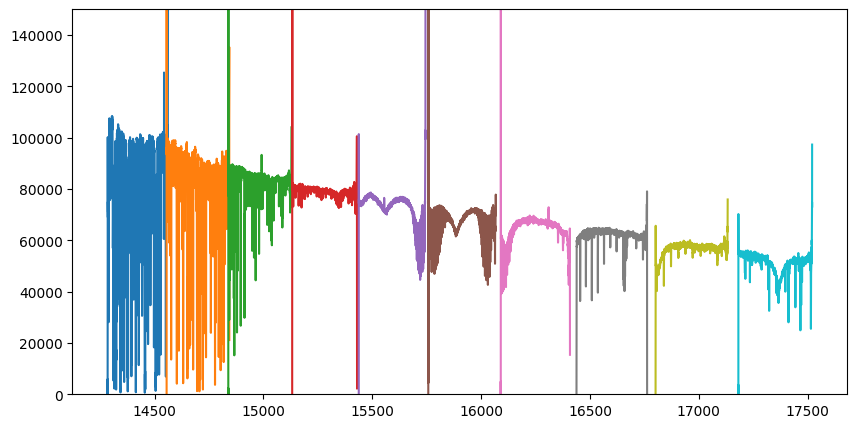

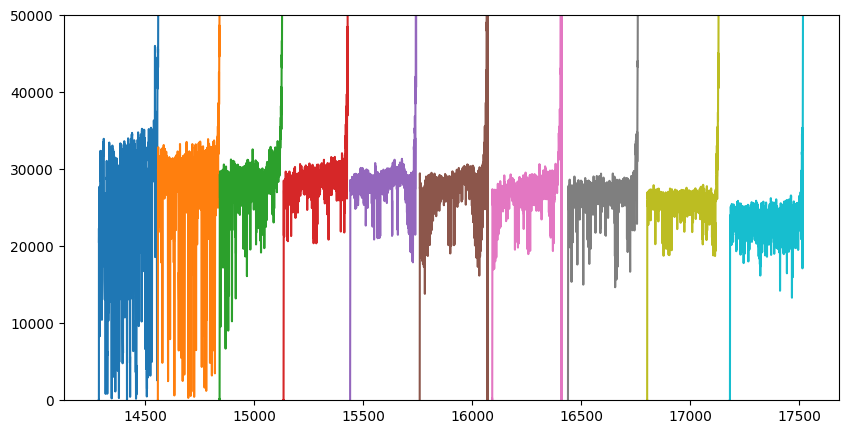

(2041,)


In [8]:
# Plot the telluric standard spectrum
plt.figure(figsize = (10,5))
for ii in range(num_orders): 
    plt.plot(wave_std_uc[ii, mask_std_uc[ii,:]>0], flux_std_uc[ii,mask_std_uc[ii,:]>0])
plt.ylim(0,1.5e5)
plt.show()

# Plot the science target spectrum
plt.figure(figsize = (10,5))
for ii in range(num_orders): 
    plt.plot(wave_GL[ii, mask_GL[ii,:]>0], flux_GL[ii,mask_GL[ii,:]>0])
plt.ylim(0,5.0e4)
plt.show()

print(np.shape(wave_std_uc[ii, mask_std_uc[ii,:]>0]))

# Extract the PHOENIX model of the standard from the sensitivity function file

***
When the sensitivity function is computed, PypeIt fits the continuum of the standard data to the reference model spectrum <br />
which in this case is the A0V PHOENIX model. We can then take advantage of this to continuum normalize the telluric standard <br />
spectrum (since the continuum has been set to tbe that of the model) and then use the model to remove any stellar features, <br />
all in one division operation. 
***

In [9]:
wav_modl = hdu_sens[2].data['SENS_FLUXED_STD_WAVE']
flux_modl = hdu_sens[2].data['SENS_STD_MODEL_FLAM']
print(np.shape(wav_modl)) # notice that the binning here is different from that of the data

(10, 2048)


# plot only the science data to see if there are any emission lines

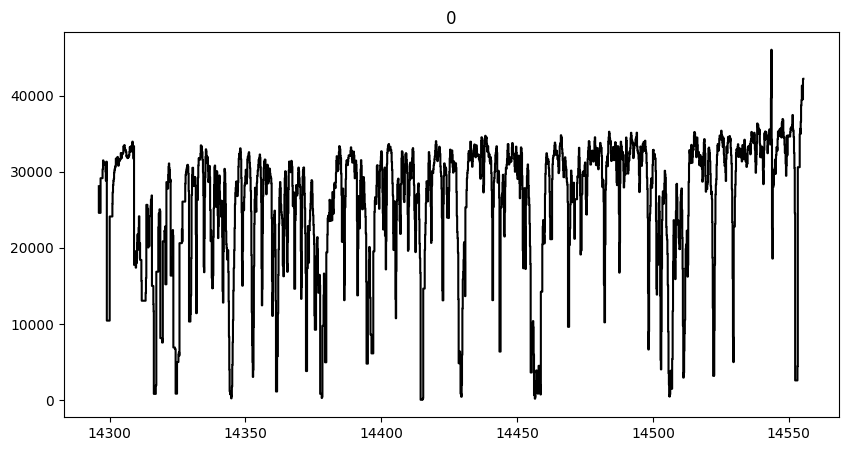

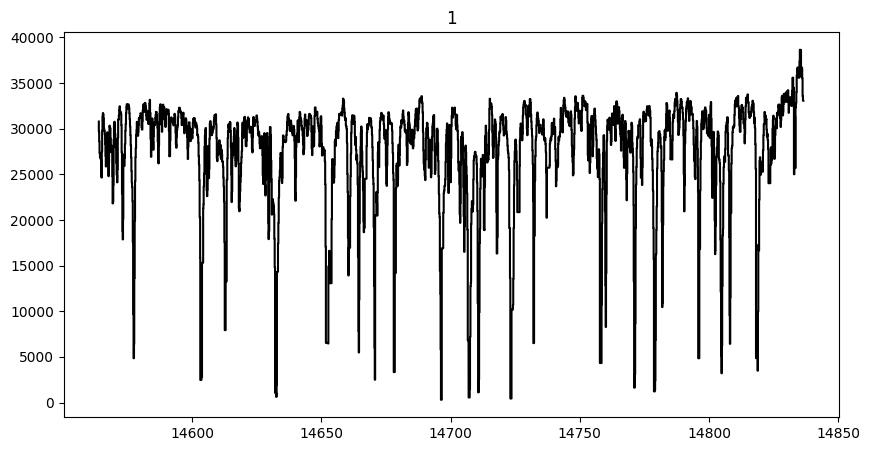

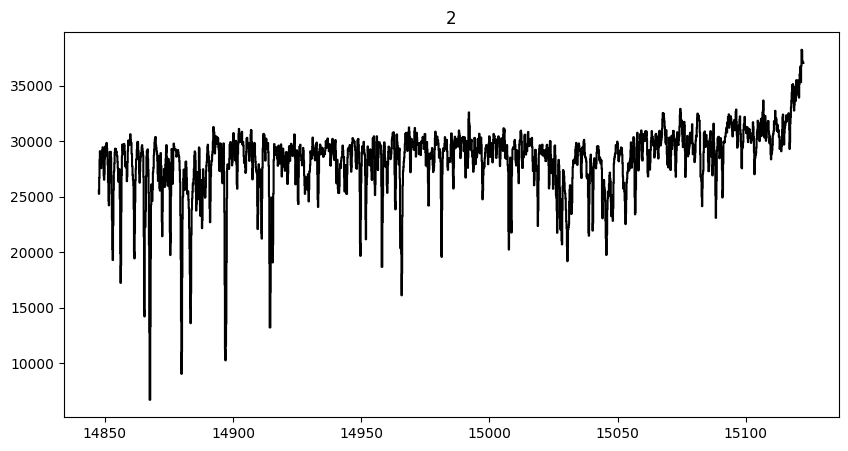

3 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


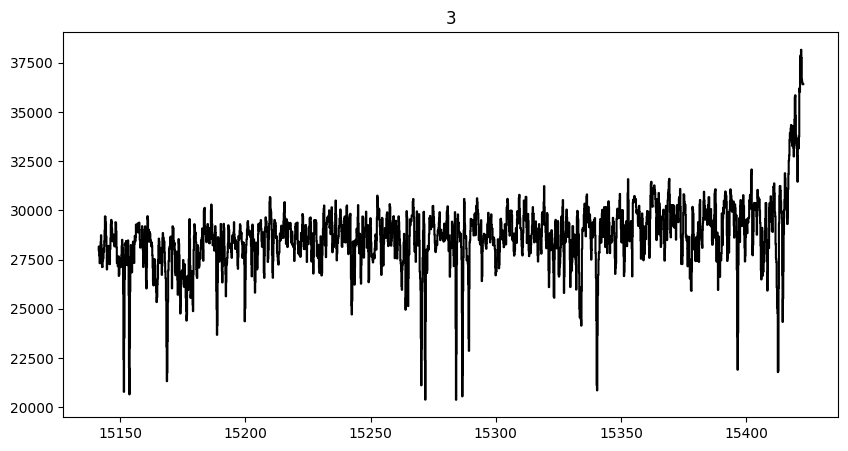

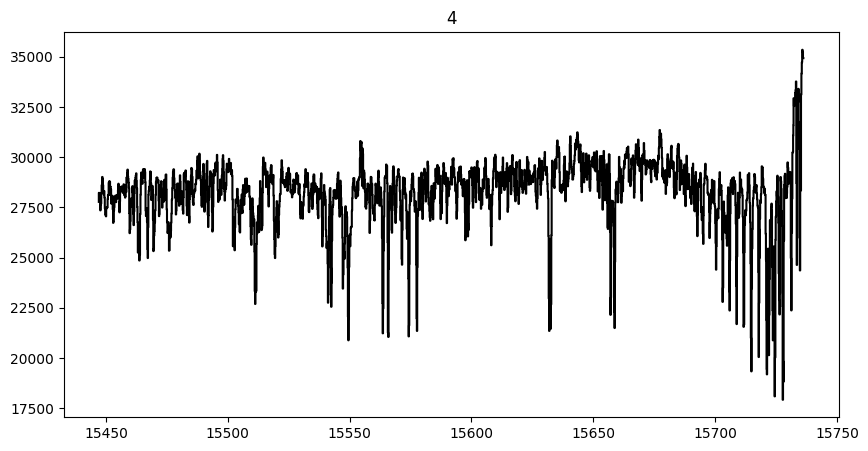

5 [1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185
 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199
 1200 1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213
 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225 1226 1227
 1228 1229 1230 1231 1232 1233 1234 1235 1236]


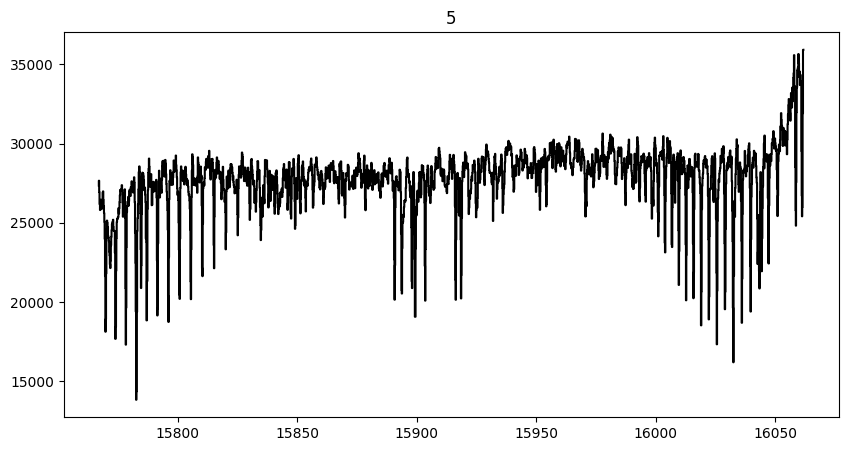

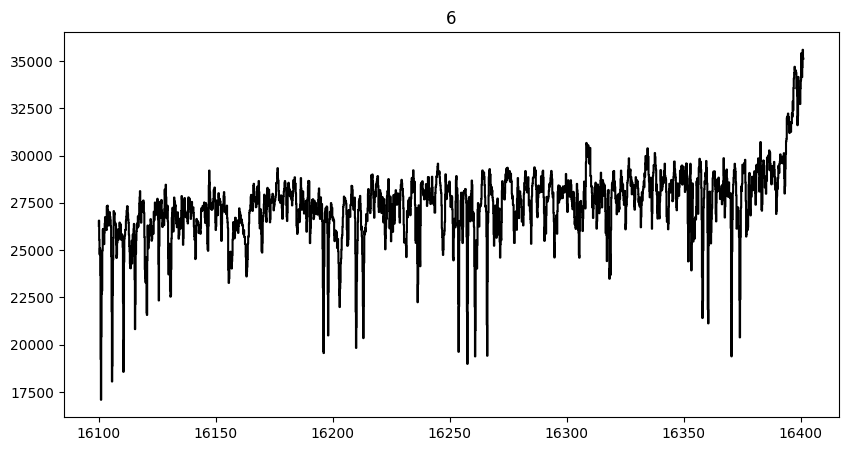

7 [1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632
 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646
 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660
 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674
 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688
 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 1701 1702
 1703 1704 1705 1706 1707 1708 1709 1710 1711]


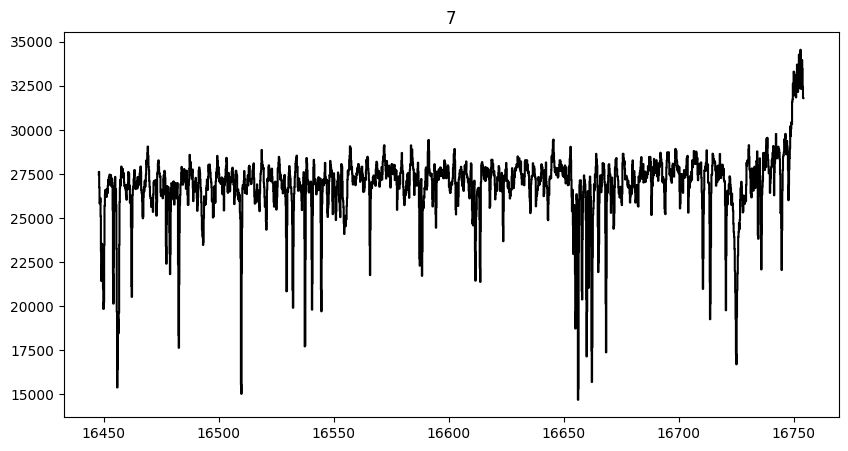

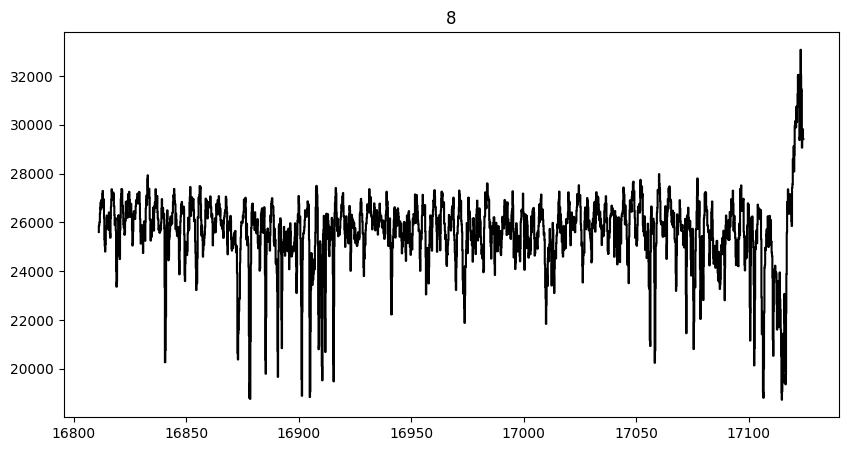

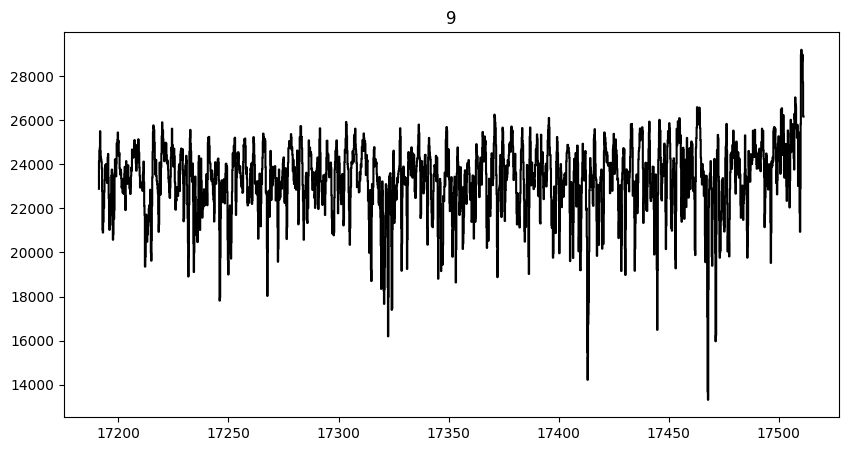

In [10]:
for ii in range(num_orders):
    # extract the unmasked wavelength vector for this order
    wave = wave_GL[ii, mask_GL[ii,:]>0][50:-50]
    # extract the unmasked pixels for this order and divide by the continuum
    dat_flat_GL = flux_GL[ii,mask_GL[ii,:]>0][50:-50]
    plt.figure(figsize = (10,5))
    plt.step(wave, dat_flat_GL, 'k-')
    # print the index number range for the region around the wavelength
    # if ii == 1: print(ii, np.where(np.logical_and(wave > 20325, wave < 20350))[0])
    # if ii == 2: print(ii, np.where(np.logical_and(wave > 21210, wave < 21230))[0])
    # if ii == 3: print(ii, np.where(np.logical_and(wave > 21640, wave < 21700))[0])
    if ii == 3: print(ii, np.where(np.logical_and(wave > 15138, wave < 15150))[0])
    if ii == 5: print(ii, np.where(np.logical_and(wave > 15945, wave < 15955))[0])
    if ii == 7: print(ii, np.where(np.logical_and(wave > 16705, wave < 16720))[0])
    #if ii == 5: print(ii, np.where(np.logical_and(wave > 15138, wave < 15150))[0])
    #plt.ylim(0,2.0)
    plt.title(str(ii))
    plt.show()


## Plot the model and the standard, then continuum normalize by dividing the standard by the model to get a telluric spectrum

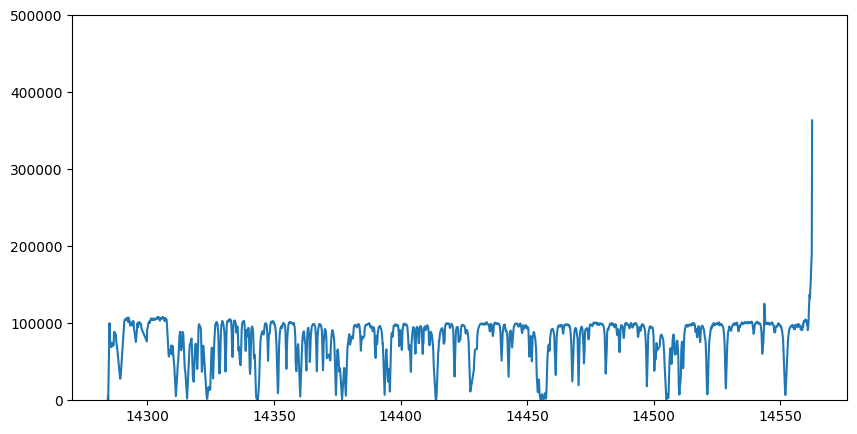

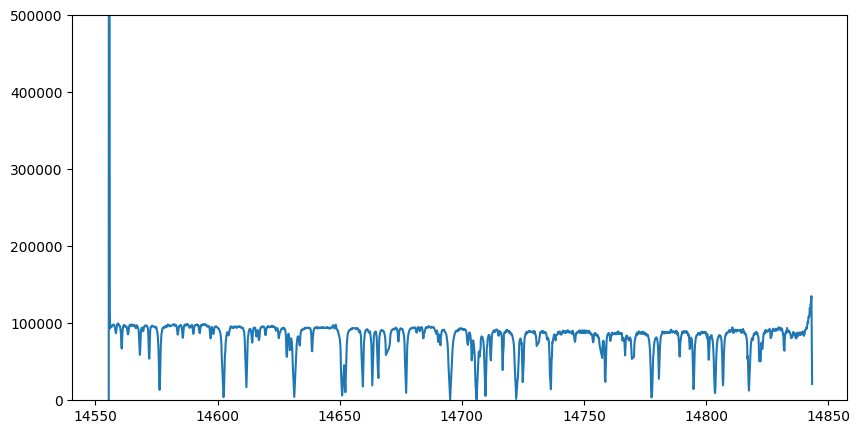

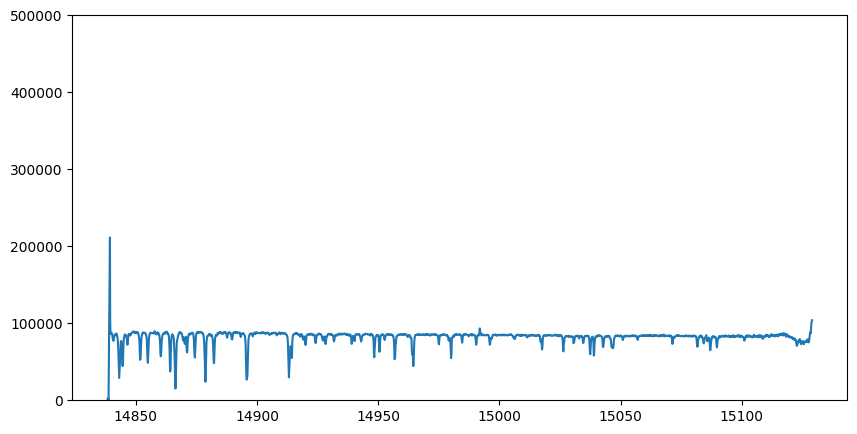

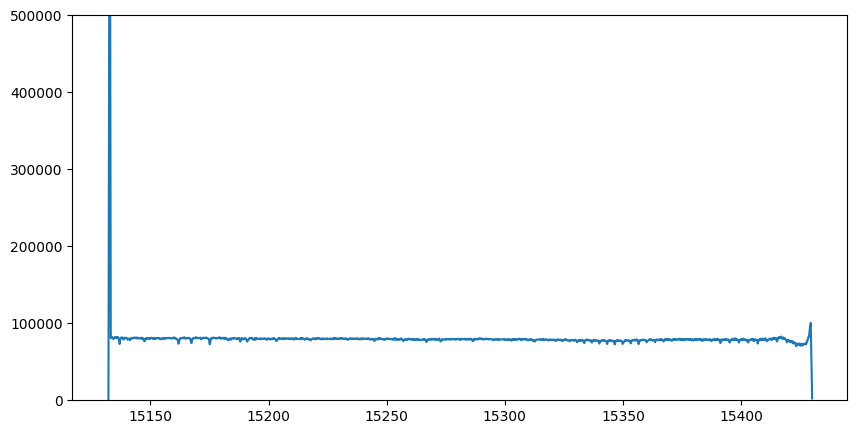

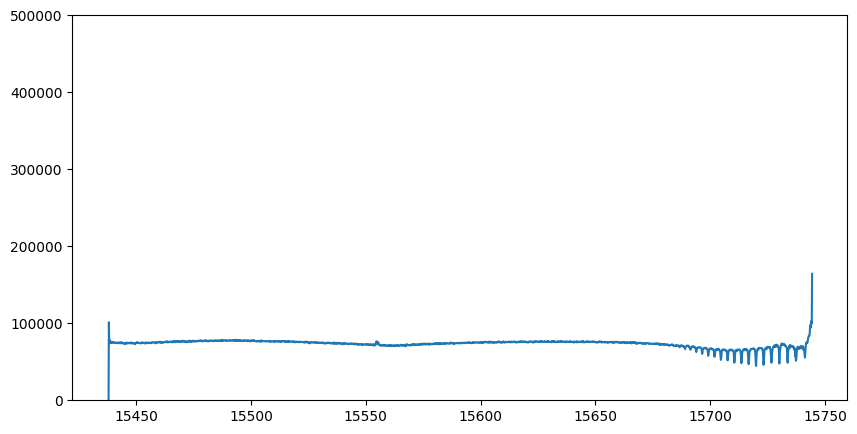

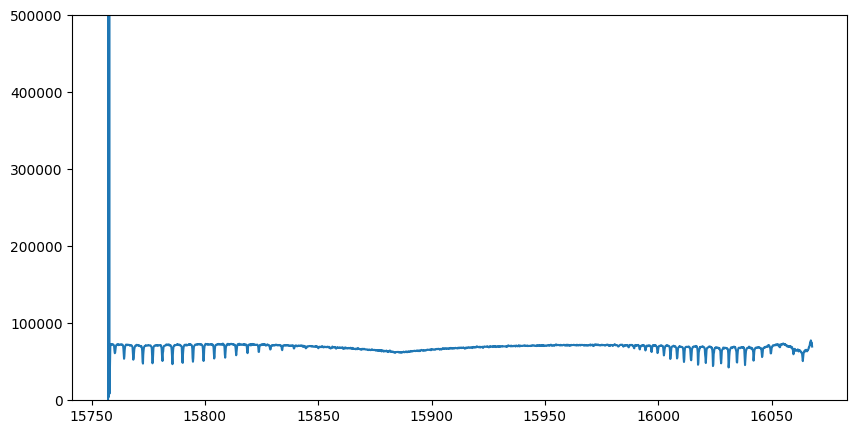

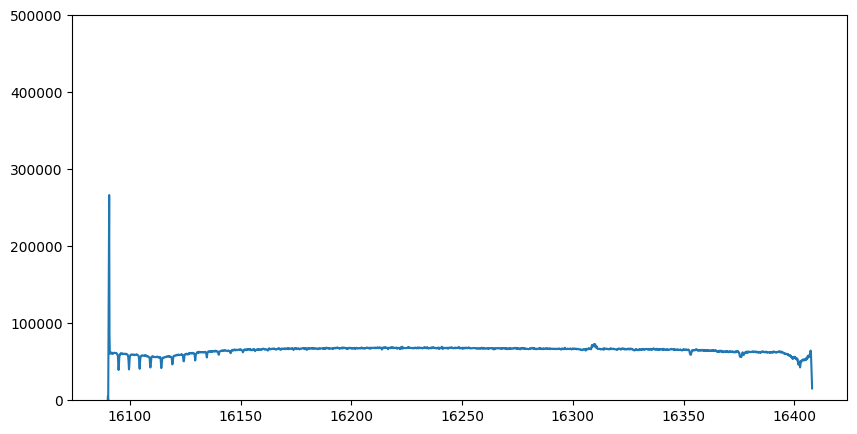

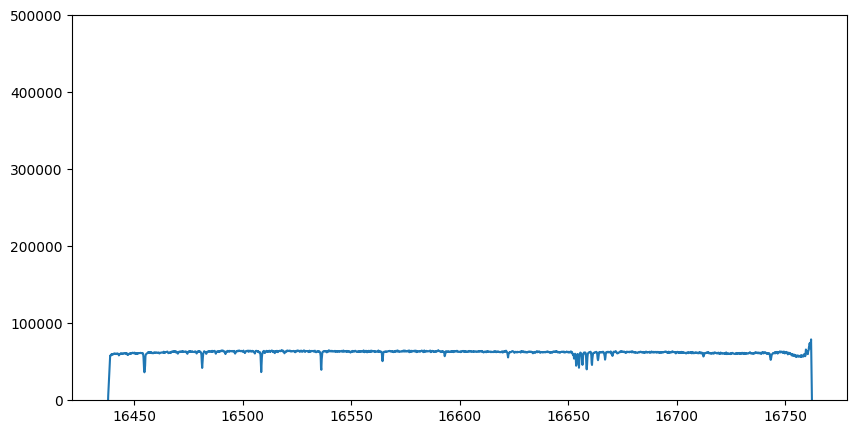

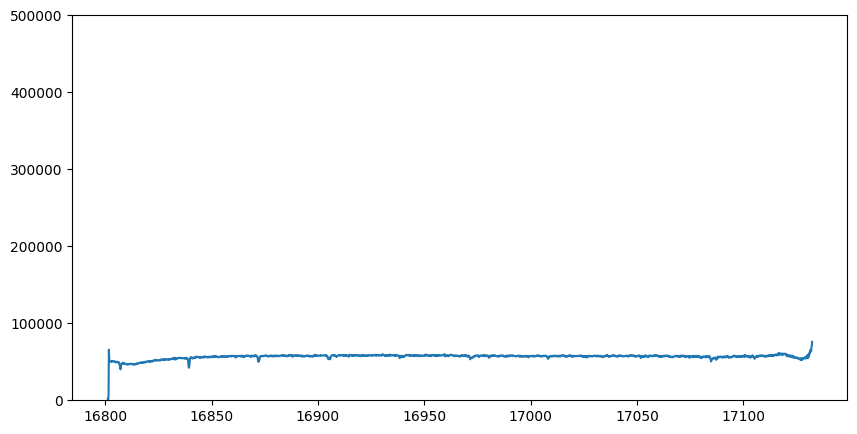

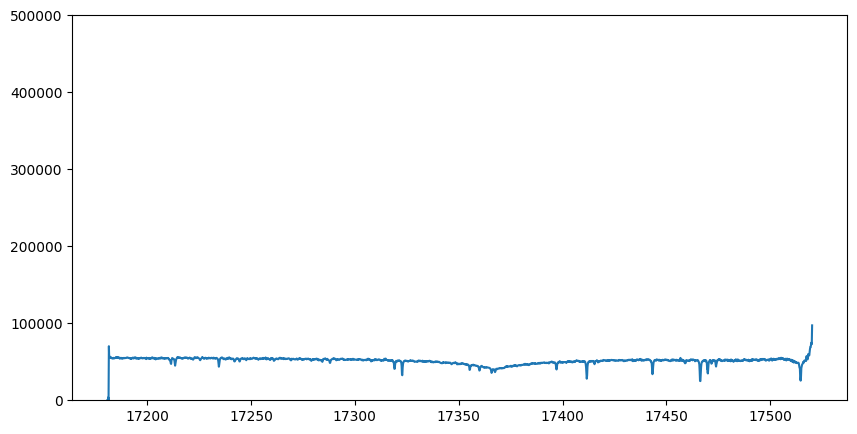

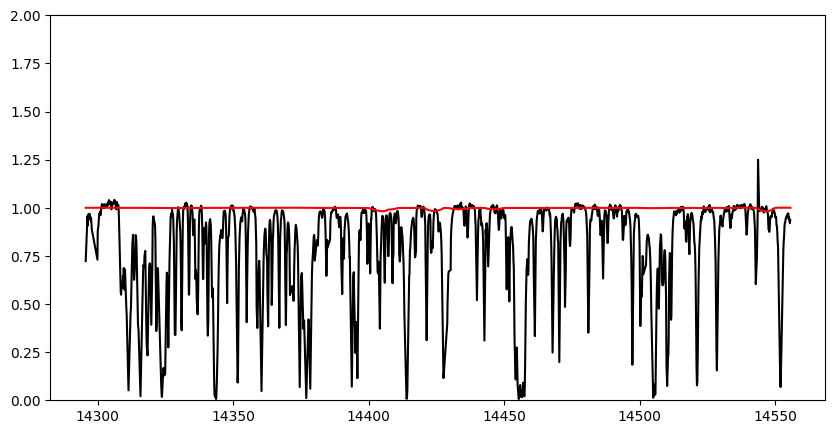

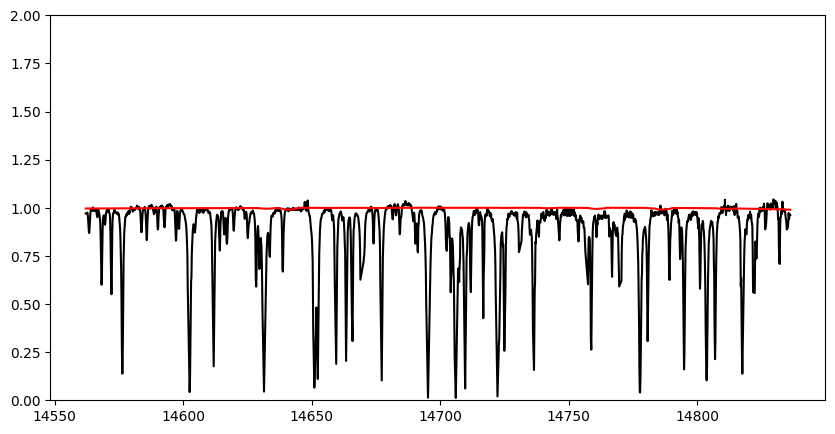

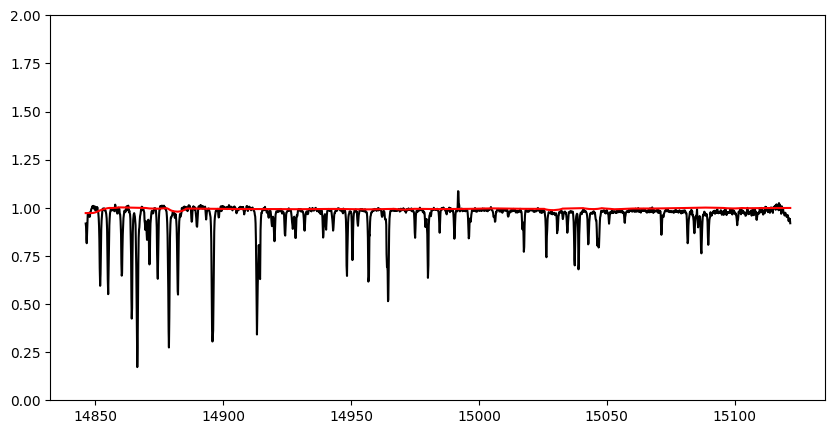

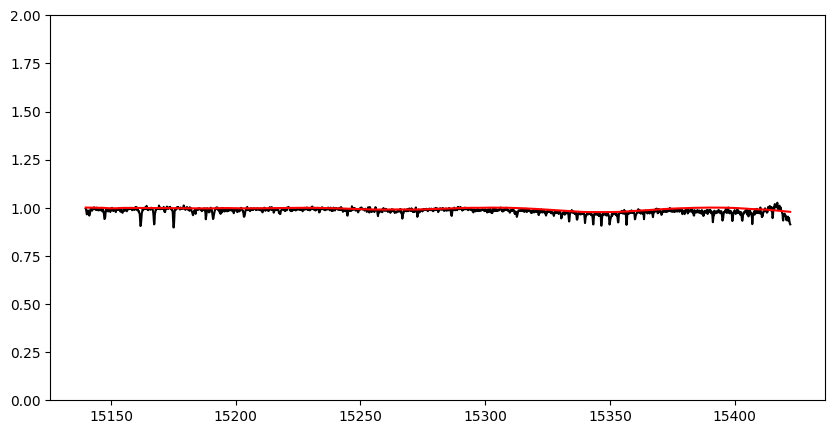

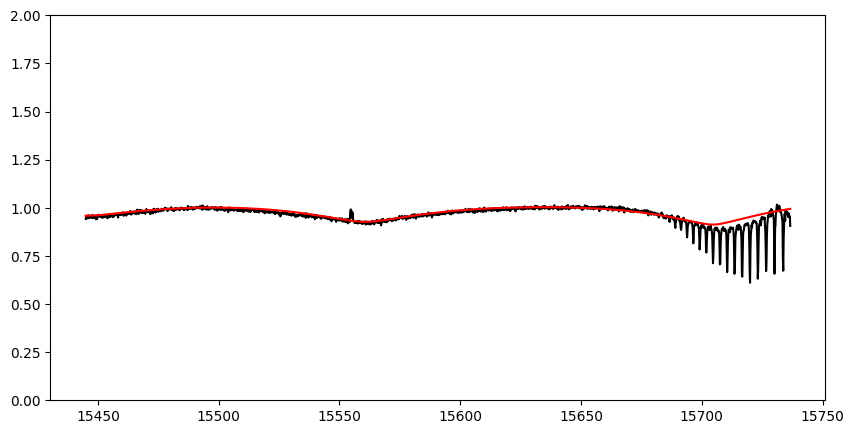

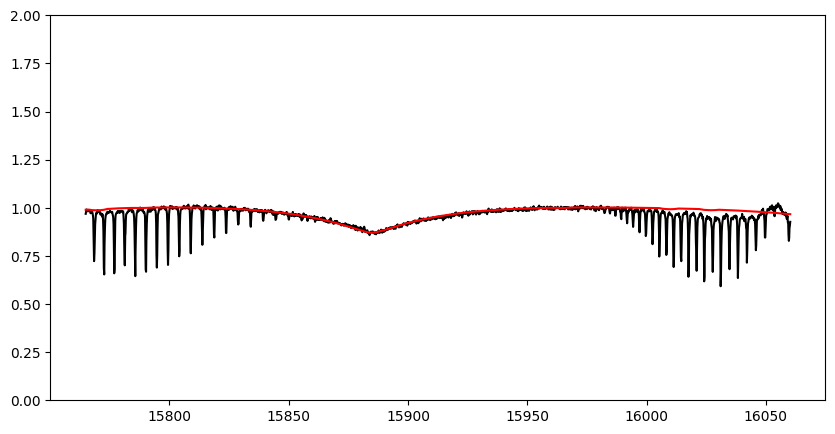

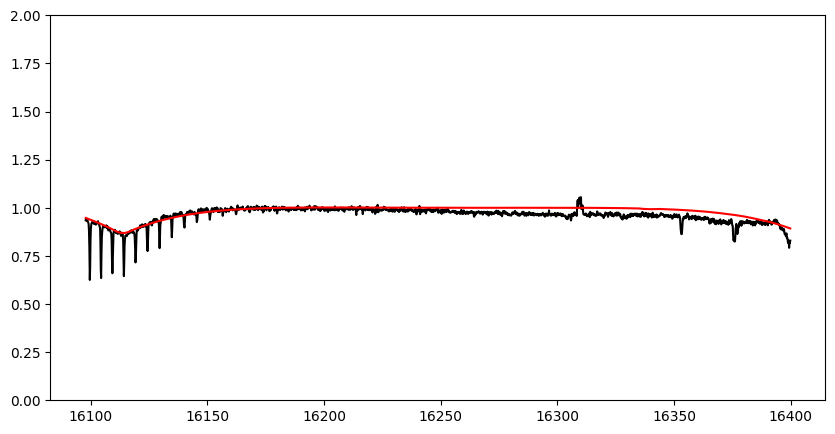

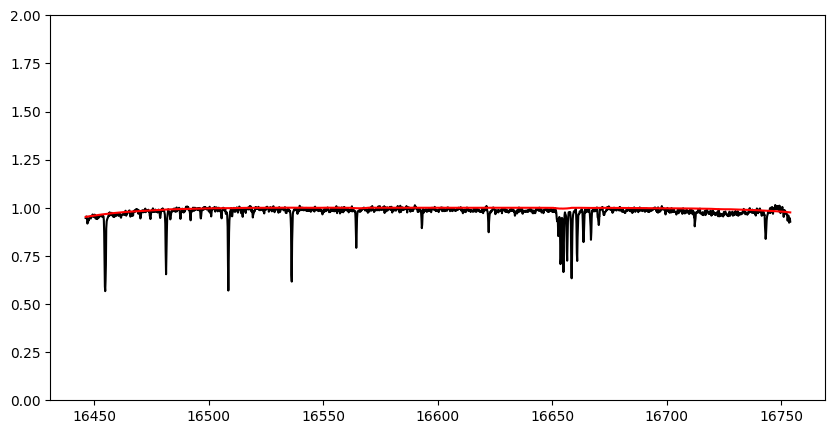

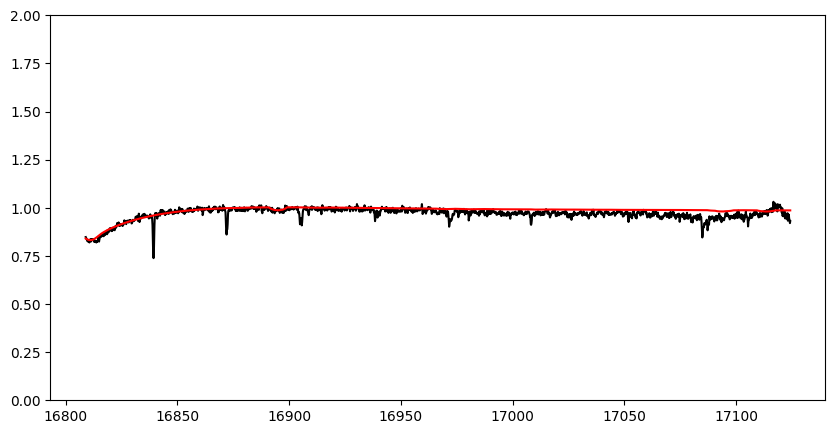

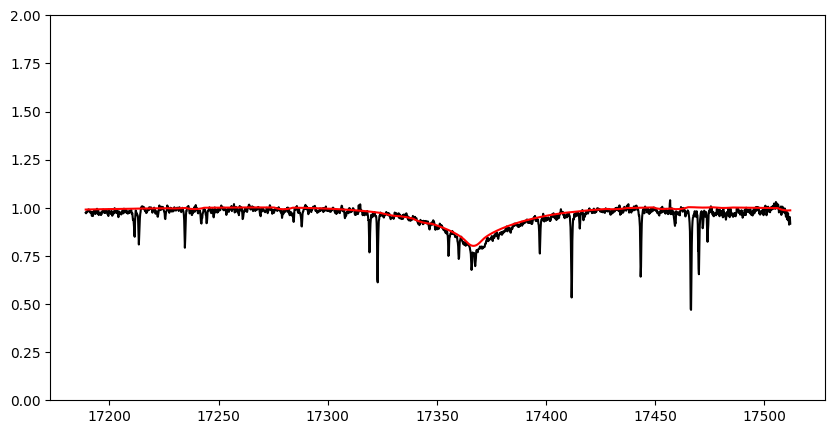

In [11]:
#Plot the standard spectrum to see how it looks
for ii in range(num_orders): 
    plt.figure(figsize = (10,5))
    plt.plot(wave_std_uc[ii, mask_std_uc[ii,:]>0], flux_std_uc[ii,mask_std_uc[ii,:]>0])
    plt.ylim(0,5.0e5)
    plt.show()

# define some lists to save the telluric continuum and the flattened model spectrum we'll use
tell_modl = []
tell_cont = []
# RV of the Standard to line up with the phoenix model
rv=0.0
for ii in range(num_orders):
    # broaden the PHOENIX model of the standard and then interpolate it onto the wavelength scale of the observed standard
    #modl_spec = np.interp(wave_std_uc[ii,mask_std_uc[ii,:]>0][50:-50], wav_modl[ii,:], 
    #                   rot_int_cmj(wav_modl[ii,:], flux_modl[ii,:], 150.0))
    modl_spec = scipy.interpolate.interp1d(wav_modl[ii,:], rot_int_cmj(wav_modl[ii,:], flux_modl[ii,:], 70.0), kind = 'quadratic', bounds_error = False, fill_value = 0.0)(wave_std_uc[ii,mask_std_uc[ii,:]>0][50:-50]*(1-rv/2.9979e5))
    # normalize the telluric model
    modl_spec_flat = modl_spec / cont_fit(modl_spec)
    # normalize the standard
    # First compute the continuum for the order
    # if there were any regions with emission lines, they could be masked out by adding the 
    # regions keyword below. A region is defined in pixel space as [blue_pixel, red_pixel], 
    # and the regions would be a list of these. So the argument would be regions = [[blue_pix1, red_pix1], [blue_pix2, red_pix2]]
    #if ii == 1: regions = [[209,331]]
    #elif ii == 2: regions = [[1753,1846]]
    if ii == 3: regions = [[10,70]]
    elif ii == 5: regions = [[1180,1245]]
    elif ii == 7: regions = [[1624,1710]]
    else: regions = None
    #regions = None
    #print(regions)
    dat_cont = cont_fit(flux_std_uc[ii,mask_std_uc[ii,:]>0][50:-50], regions = regions)
    dat_flat = flux_std_uc[ii,mask_std_uc[ii,:]>0][50:-50]/dat_cont

    #save the continuum used and the telluric spectrum for this order
    tell_cont.append(dat_cont)
    tell_modl.append(dat_flat/modl_spec_flat)
    # plot the two to see how it went
    plt.figure(figsize = (10,5))
    plt.plot(wave_std_uc[ii, mask_std_uc[ii,:]>0][50:-50], dat_flat, 'k-')
    plt.plot(wave_std_uc[ii, mask_std_uc[ii,:]>0][50:-50], modl_spec_flat, 'r-')
    #plt.plot(wave_std_uc[ii, :], wave_std_uc[ii,:])
    #plt.xlim(9000,15000)
    plt.ylim(0,2.0)
    plt.show()


### For each order, find the shift between the telluric spectrum and the data, apply the shift, and divide the data by the shifted telluric spectrum

If the shift computed by the cross-correlation is bad, which can happen when orders have few tellurics, the line to compute the shifts (wvutils.xcorr_shift is the function)  <br />
should be replaced with a defined pixel shift for each order. Alternatively, if there is no shift, then set shift_cc = 0.0. 

In [12]:
import scipy.optimize


def scale_tell(spec, scale_fact):
    return spec[0]/(1 - scale_fact * (1 - spec[1]))

def calc_best_scale(spec):
    popt, pcov = scipy.optimize.curve_fit(scale_tell, spec, np.ones_like(spec[0]), bounds = [(0.0), (2.0)])
    return popt[0]

### Using a reference order (in this exercise, order 2 is good, echelle order=51) and a reference wavelength range dominated by telluric features (14900 - 15025 here), we will compute the best-fit scaling for telluric features in the spectrum. The procedure will mimic the telluric correction process for all susbsequent orders, so some code and comments are repeated below. 

In [13]:
from pypeit.core.wavecal import wvutils
ii = 2
lam_min = 14920.0
lam_max = 15000.0

# extract the unmasked wavelength vector for this order
wave = wave_GL[ii, mask_GL[ii,:]>0][50:-50]
# compute the continuum for the order
# if there were any regions with emission lines, they could be masked out by adding the 
# regions keyword below. A region is defined in pixel space as [blue_pixel, red_pixel], 
# and the regions would be a list of these. So the argument would be regions = [[blue_pix1, red_pix1], [blue_pix2, red_pix2]]
dat_cont_GL = cont_fit(flux_GL[ii,mask_GL[ii,:]>0][50:-50])
# extract the unmasked pixels for this order and divide by the continuum
dat_flat_GL = flux_GL[ii,mask_GL[ii,:]>0][50:-50]/dat_cont_GL
# interpolate the telluric spectrum onto this wavelength scale
tell_fit_GL = scipy.interpolate.interp1d(wave_std_uc[ii, mask_std_uc[ii,:]>0][50:-50], tell_modl[ii], kind = 'quadratic', bounds_error = False, fill_value = 0.0)(wave_GL[ii, mask_GL[ii,:]>0][50:-50])

# compute the relative shift between the two
shift_cc, corr_cc = wvutils.xcorr_shift(1-dat_flat_GL, 1-tell_fit_GL, debug=False, percent_ceil=50.0, max_lag_frac=0.01) # max_lag_frac restricts the fraction of the order by which to search for a shift

wav_shift = np.median(wave[1:] - wave[0:-1])*shift_cc
print(f'wav_shift = {wav_shift} Angstroms')
# Correct for any small pixel shifts between the telluric and the science target
tell_fit_GL_shift = scipy.interpolate.interp1d(np.arange(len(wave))+shift_cc, tell_fit_GL, kind = 'quadratic', bounds_error = False, fill_value = 0.0)(np.arange(len(wave)))

#now scale the line depths by the necessary factor to match the observation

inds = np.where(np.logical_and(wave > lam_min, wave < lam_max))[0]
tell_scale = calc_best_scale([dat_flat_GL[inds], tell_fit_GL_shift[inds]])
print('tell scale = ', tell_scale)
tell_fit_GL_scale = 1 - tell_scale*(1 - tell_fit_GL_shift)



wav_shift = 1.2927430545104264 Angstroms
tell scale =  0.9651554298946017


(1681,) (1681,)
8.092130056620533
wav_shift = 1.1208209356113197 Angstroms
tell scale =  0.9651554298946017


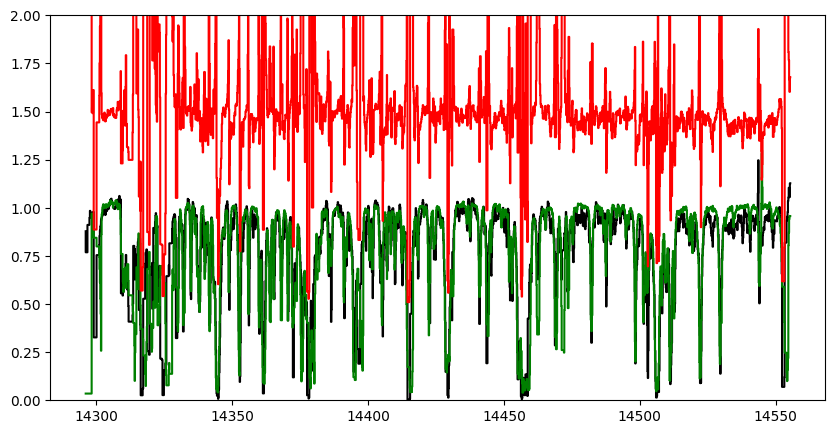

(1856,) (1856,)
8.098799835915031
wav_shift = 1.1371414061847824 Angstroms
tell scale =  0.9651554298946017


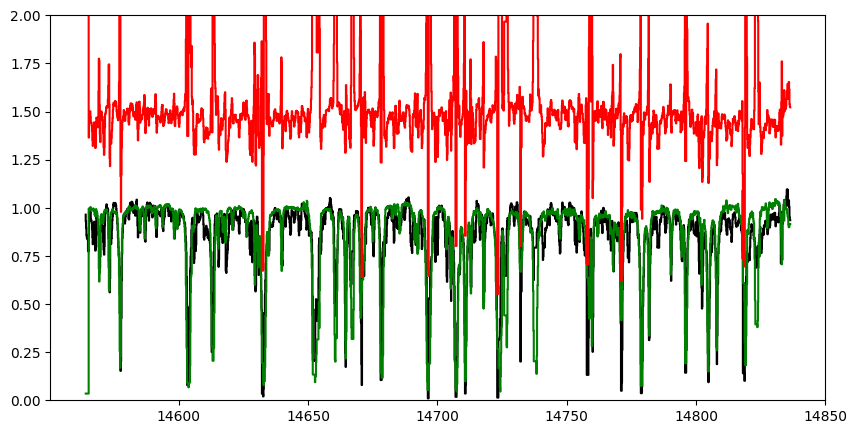

(1911,) (1911,)
9.141154592778818
wav_shift = 1.3159890256207651 Angstroms
tell scale =  0.9651554298946017


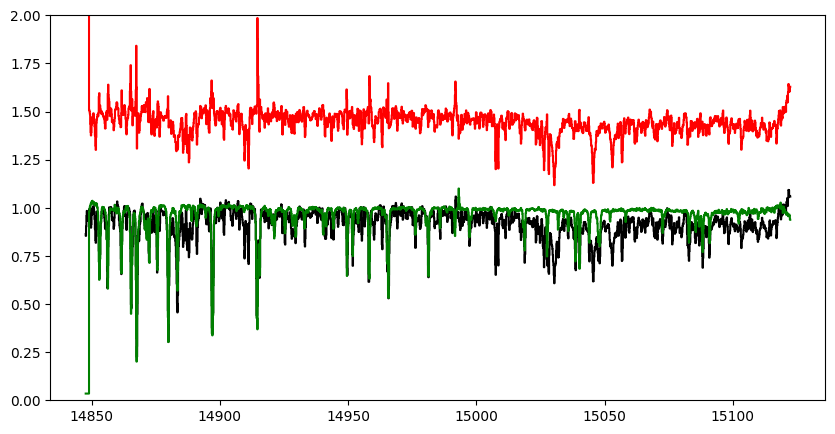

(1923,) (1923,)
9.0
wav_shift = 1.3223505432115417 Angstroms
tell scale =  0.9651554298946017


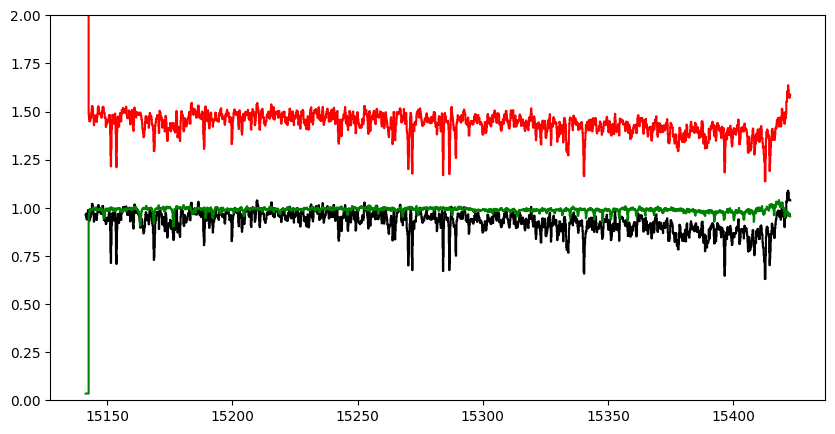

(1933,) (1933,)
8.59785241586573
wav_shift = 1.2812334443204165 Angstroms
tell scale =  0.9651554298946017


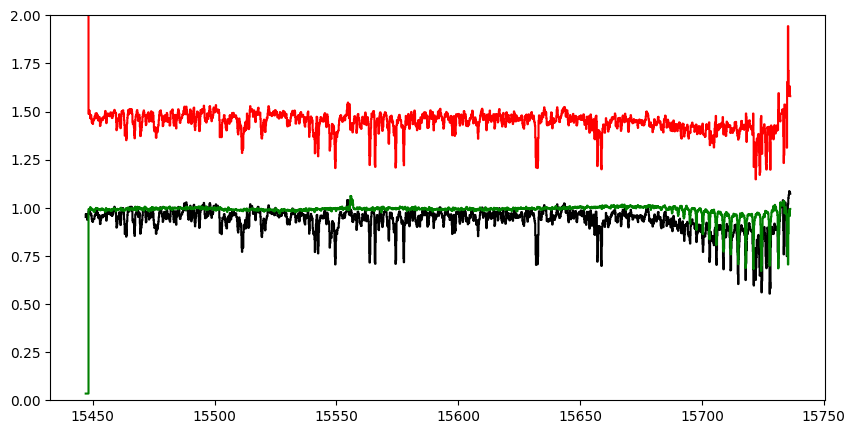

(1934,) (1934,)
9.025322249353763
wav_shift = 1.383186890395408 Angstroms
tell scale =  0.9651554298946017


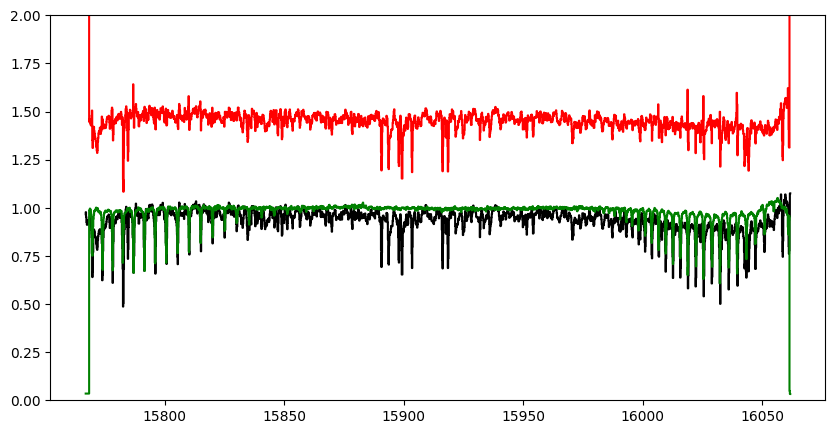

(1935,) (1935,)
-23.00179537013875
wav_shift = -3.599243523441403 Angstroms
tell scale =  0.9651554298946017


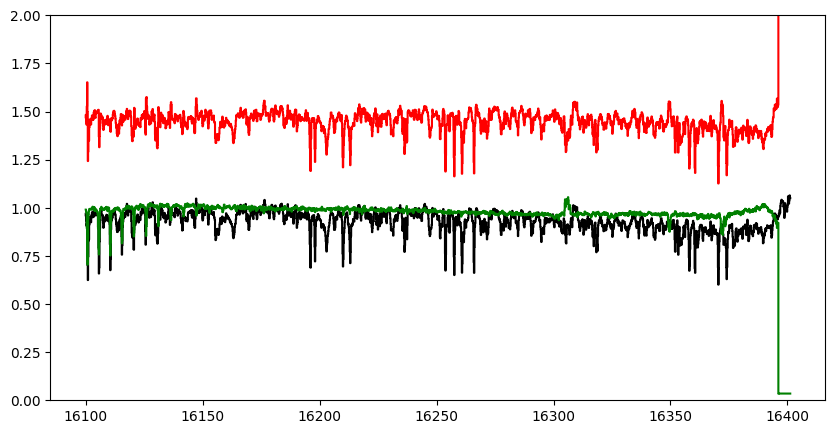

(1926,) (1926,)
9.157301707764304
wav_shift = 1.4673590190135075 Angstroms
tell scale =  0.9651554298946017


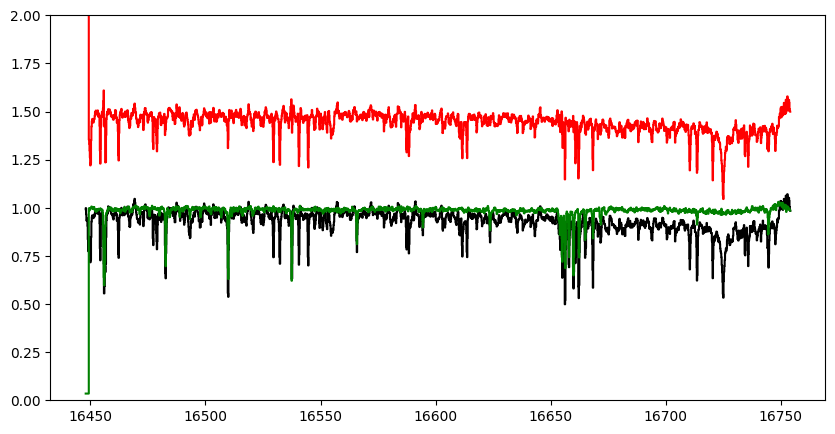

(1927,) (1927,)
-89.68249873176403
wav_shift = -14.658443073135611 Angstroms
tell scale =  0.9651554298946017


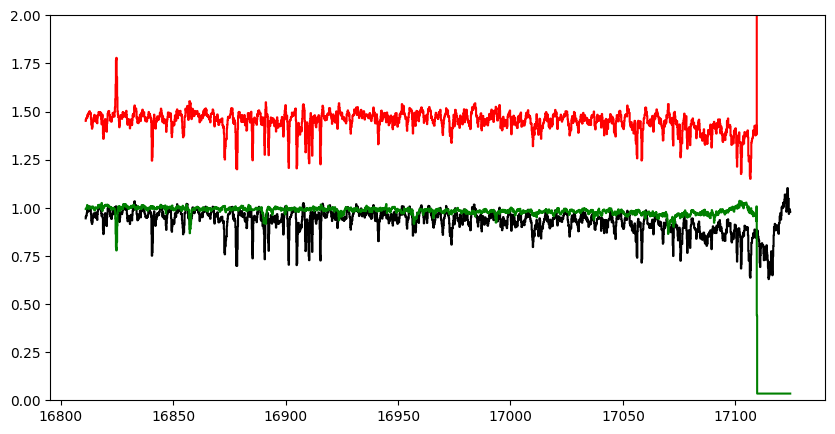

(1924,) (1924,)
9.22063497327575
wav_shift = 1.539293959346278 Angstroms
tell scale =  0.9651554298946017


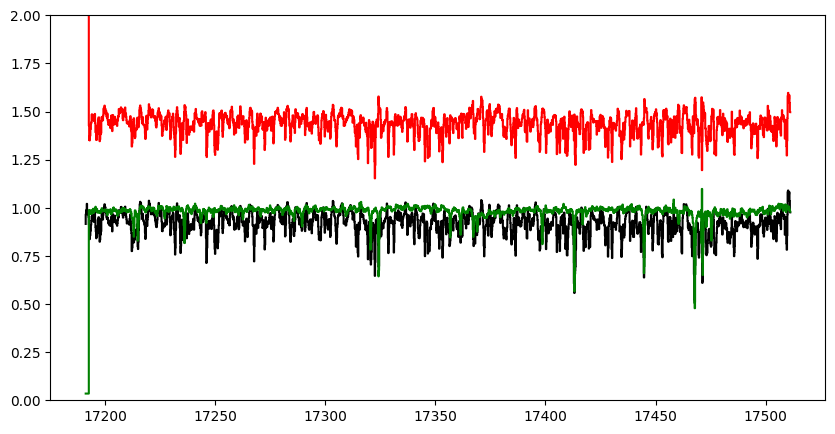

In [15]:


from pypeit.core.wavecal import wvutils
# initialize lists to save the telluric corrected spectral information
flux_GL_notell = []    # telluric corrected science spectrum
wave_GL_notell = []     # wavelength scale for the spectrum
ivar_GL_notell = []     # inverse variance, after flux normalization
flux_tellspec = []      # telluric spectrum used to correct spectrum
cont_GL_notell = []     # continuum used in continuum normalization
for ii in range(num_orders):
    # extract the unmasked wavelength vector for this order
    wave = wave_GL[ii, mask_GL[ii,:]>0][50:-50]
    # compute the continuum for the order
    # if there were any regions with emission lines, they could be masked out by adding the 
    # regions keyword below. A region is defined in pixel space as [blue_pixel, red_pixel], 
    # and the regions would be a list of these. So the argument would be regions = [[blue_pix1, red_pix1], [blue_pix2, red_pix2]]
    if ii == 3: regions = [[10,47]]
    elif ii == 5: regions = [[1180,1245]]
    elif ii == 7: regions = [[1624,1710]]
    else: regions = None
    dat_cont_GL = cont_fit(flux_GL[ii,mask_GL[ii,:]>0][50:-50])
    # extract the unmasked pixels for this order and divide by the continuum
    dat_flat_GL = flux_GL[ii,mask_GL[ii,:]>0][50:-50]/dat_cont_GL
    # interpolate the telluric spectrum onto this wavelength scale
    tell_fit_GL = scipy.interpolate.interp1d(wave_std_uc[ii, mask_std_uc[ii,:]>0][50:-50], tell_modl[ii], kind = 'quadratic', bounds_error = False, fill_value = 0.0)(wave_GL[ii, mask_GL[ii,:]>0][50:-50])
    print(np.shape(dat_flat_GL), np.shape(tell_fit_GL))
    # compute the relative shift between the two
    shift_cc, corr_cc = wvutils.xcorr_shift(1-dat_flat_GL, 1-tell_fit_GL, debug=False, percent_ceil=50.0, max_lag_frac=0.05) # max_lag_frac restricts the fraction of the order by which to search for a shift
    if ii == 3: shift_cc = 9.0
    print(shift_cc)
    wav_shift = np.median(wave[1:] - wave[0:-1])*shift_cc
    print(f'wav_shift = {wav_shift} Angstroms')
    # Correct for any small pixel shifts between the telluric and the science target
    tell_fit_GL_shift = scipy.interpolate.interp1d(np.arange(len(wave))+shift_cc, tell_fit_GL, kind = 'quadratic', bounds_error = False, fill_value = 0.0)(np.arange(len(wave)))

    #now scale the line depths by the necessary factor to match the observation
    #tell_scale = calc_best_scale([dat_flat_GL, tell_fit_GL_shift])
    print('tell scale = ', tell_scale)
    tell_fit_GL_scale = 1 - tell_scale*(1 - tell_fit_GL_shift)

    # save these spectra for later
    flux_GL_notell.append(dat_flat_GL/tell_fit_GL_scale)
    wave_GL_notell.append(wave)
    ivar_GL_notell.append(ivar_GL[ii,mask_GL[ii,:]>0][50:-50]/dat_cont_GL)
    flux_tellspec.append(tell_fit_GL_scale)
    cont_GL_notell.append(np.interp(np.arange(len(wave)), np.arange(len(wave))+shift_cc, dat_cont_GL))

    # plot the results
    plt.figure(figsize = (10,5))
    plt.step(wave, dat_flat_GL, 'k-')
    plt.step(wave, tell_fit_GL_scale, 'g-')
    plt.step(wave, dat_flat_GL/tell_fit_GL_scale+0.5, 'r-')
    plt.ylim(0,2.0)
    plt.show()


1681
1856
1911
1923
1933
1934
1935
1926
1927
1924


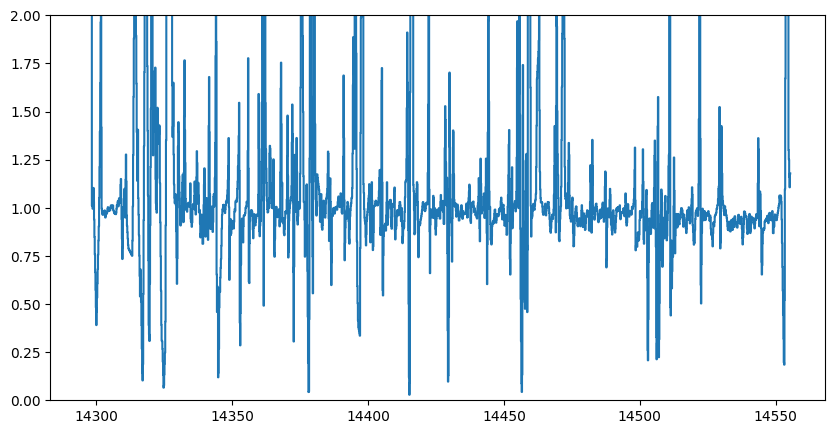

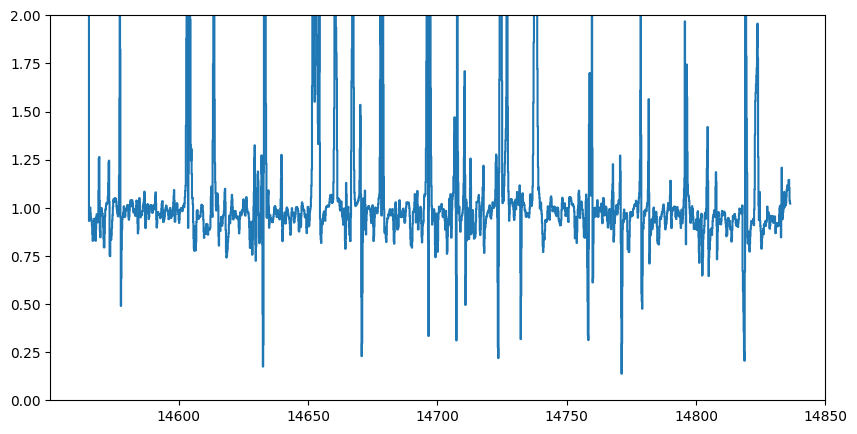

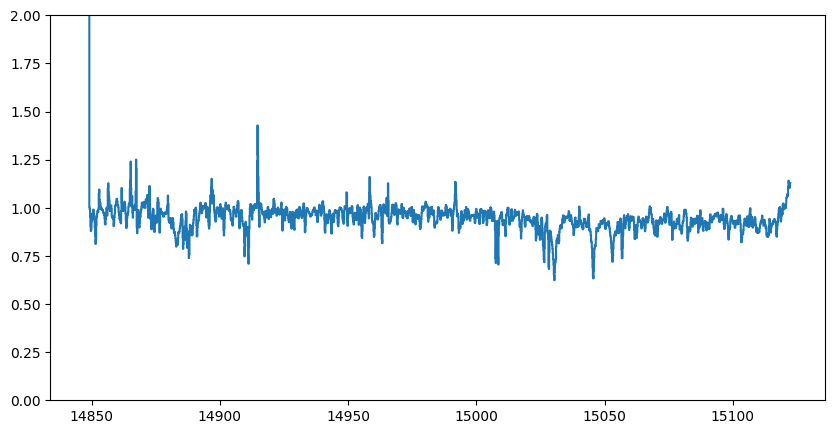

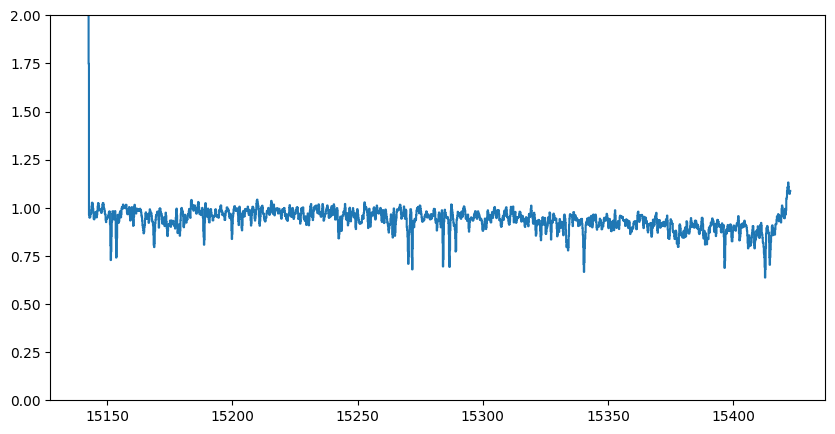

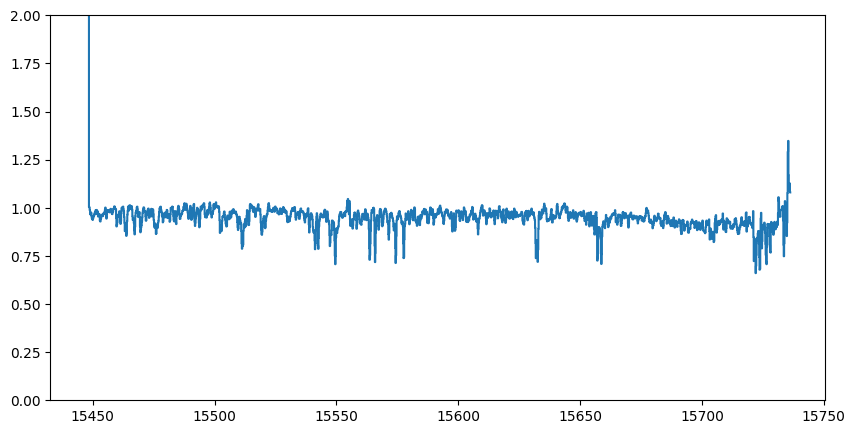

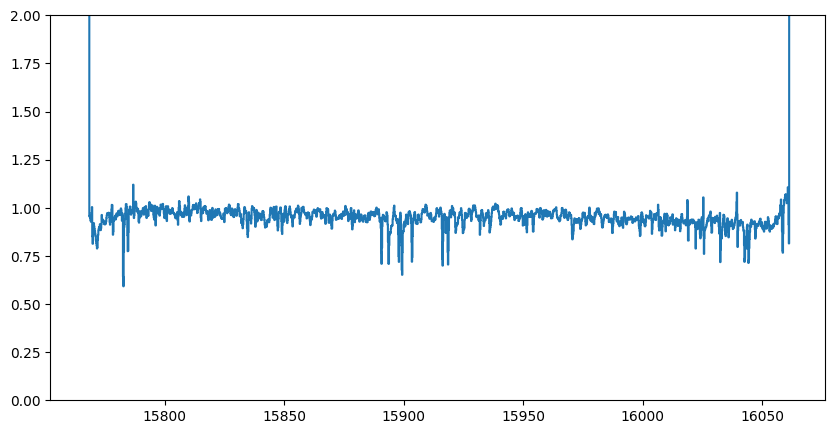

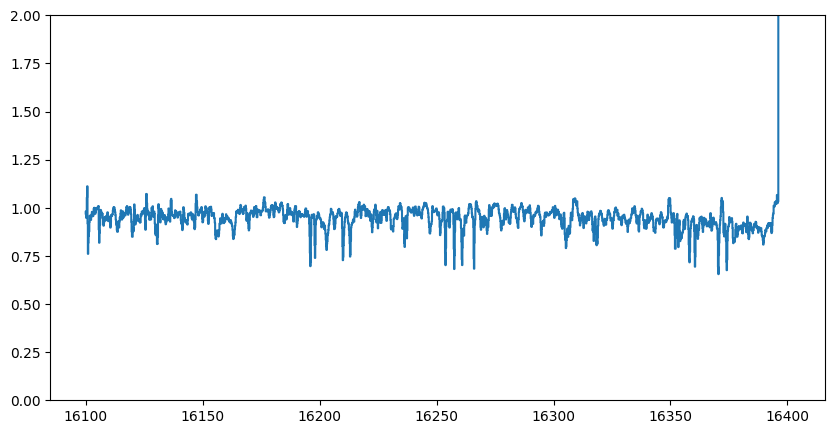

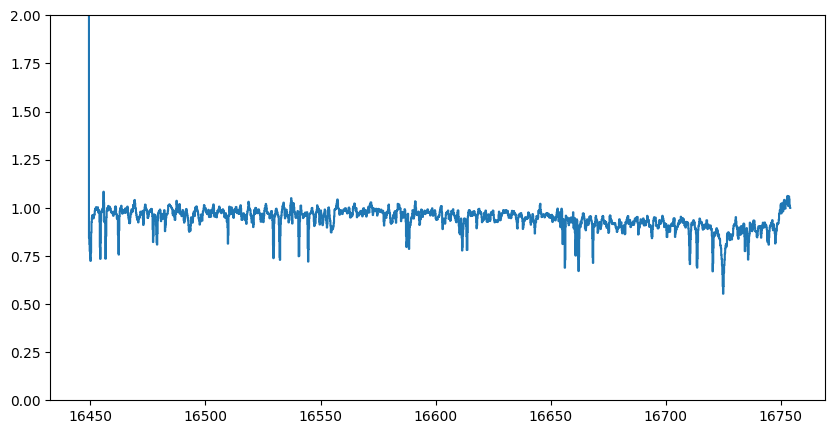

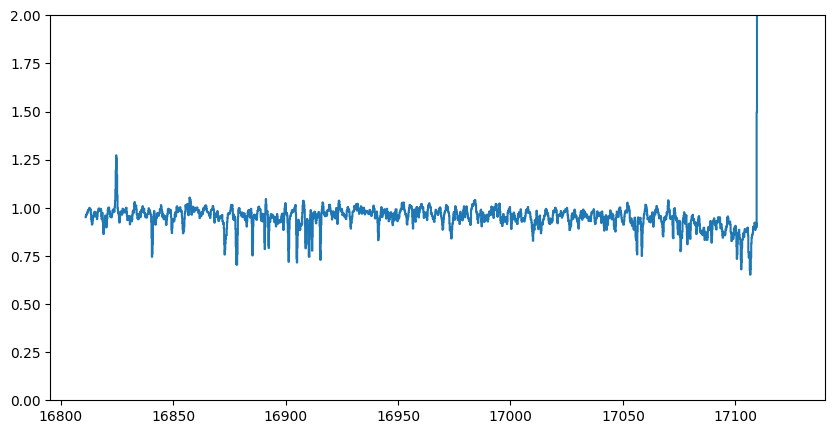

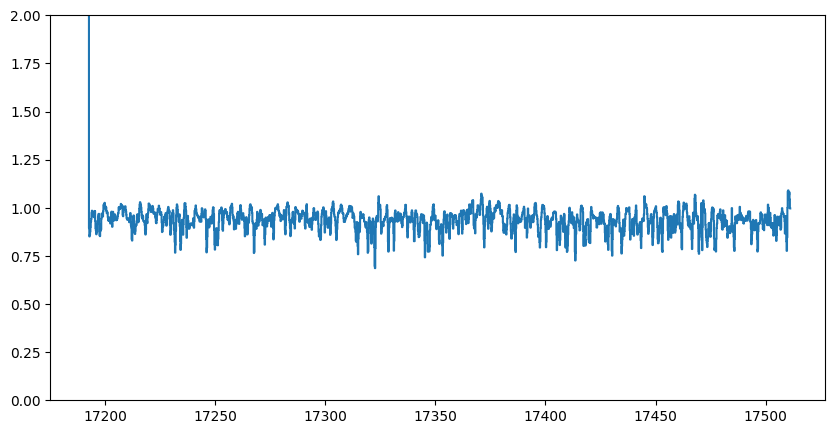

In [16]:
#In order to save the telluric corrected spectra, let's rebin them to an array of consistent size. In this case,
# we'll assume that, since we cut 50 pixels from either end, a full array should have 1950 pixels and the ones 
# that have less than that have some masked values in the middle. 
for ii in range(num_orders): print(len(flux_GL_notell[ii]))
wave_GL_rebin = np.ones((num_orders, 1950))
flux_GL_rebin = np.ones((num_orders, 1950))
cont_GL_rebin = np.ones((num_orders, 1950))
ivar_GL_rebin = np.ones((num_orders, 1950))
tell_spec_rebin = np.ones((num_orders,1950))

for ii in range(num_orders):
    # compute linear wavelength for the order, assuming 1950 pixels in the order
    wave_GL_rebin[ii,:] = np.linspace(np.min(wave_GL_notell[ii]), np.max(wave_GL_notell[ii]), 1950)
    # interpolate the other vectors onto this wavelength grid
    flux_GL_rebin[ii,:] = np.interp(wave_GL_rebin[ii,:], wave_GL_notell[ii], flux_GL_notell[ii])
    ivar_GL_rebin[ii,:] = np.interp(wave_GL_rebin[ii,:], wave_GL_notell[ii], ivar_GL_notell[ii])
    tell_spec_rebin[ii,:] = np.interp(wave_GL_rebin[ii,:], wave_GL_notell[ii], flux_tellspec[ii])
    cont_GL_rebin[ii,:] = np.interp(wave_GL_rebin[ii,:], wave_GL_notell[ii], cont_GL_notell[ii])
    plt.figure(figsize = (10,5))
    plt.step(wave_GL_rebin[ii,:], flux_GL_rebin[ii,:])
    plt.ylim(0,2)
    plt.show()

In [17]:
# save the continuum fit that was used to normalize the telluric spectrum, but in the same type of 
# padded array that the telluric spectrum is saved as
tell_cont_array = np.zeros(np.shape(flux_std_uc))
for ii in range(num_orders):
    padding = np.zeros(50)
    tell_cont_array[ii, mask_std_uc[ii,:]>0] = np.append(np.append(padding, tell_cont[ii]), padding)
    

In [18]:
from astropy.table import Table
# make astropy tables to save the different pieces that went into this dataset
# NOTE: Headers still not quite figured out, so they won't have all the information we want to retain in the future
telluric_table=Table([['telluric'], [header_std_uc], [wave_std_uc],
                  [flux_std_uc], [ivar_std_uc],
                  [mask_std_uc], [tell_cont_array]],
                  names=('obj type', 'header', 'wave', 'flux', 'ivar','mask','cont_fit'))

science_og_table=Table([['science'], [header_GL], [wave_GL],
                  [flux_GL], [ivar_GL],
                  [mask_GL]],
                  names=('obj type','header' , 'wave', 'flux', 'ivar','mask'))

science_corr_table=Table([['science corrected'], [wave_GL_rebin],
                  [flux_GL_rebin], [ivar_GL_rebin], [tell_spec_rebin], [cont_GL_rebin]],
                  names=('obj type','wave', 'flux', 'ivar', 'tell_spec', 'cont_fit'))


hdulist = fits.HDUList()
hdulist.append(fits.BinTableHDU(telluric_table.as_array()))  # hdu = 1
hdulist.append(fits.BinTableHDU(science_og_table.as_array()))  # hdu = 2
hdulist.append(fits.BinTableHDU(science_corr_table.as_array()))  # hdu = 3
hdulist.writeto('GL745A_Hband_tellcorr_opt.fits', overwrite=True)


In [1]:
from astropy.io import fits

path = '/Users/ava/Desktop/Stellar_Spectra/Hband/HIP68276_telluric.Hband.coadded.fits'
hdu = fits.open(path)
data = hdu[1].data[0]

# Load the stacked per-order arrays
wave = data['wave_stack'].T     # Shape: (6, 16166)
flux = data['flux_stack'].T
mask = data['mask_stack'].T

import numpy as np

np.savez('/Users/ava/Desktop/Stellar_Spectra/Hband/telluric_standardH.npz',
         wave=wave.T, flux=flux.T, mask=mask.T)

data = np.load('/Users/ava/Desktop/Stellar_Spectra/Hband/telluric_standardH.npz')
wave = data['wave']
print(wave.shape)

(10, 21308)


 Loaded /users/ava/desktop/Spectral Website/data/h_fits/HD164259_Hband_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/h_fits/HD203473_Hband_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/h_fits/HD199381_Hband_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/h_fits/GL514_Hband_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/h_fits/GL745A_Hband_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/h_fits/GL628_Hband_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/h_fits/GL555_Hband_tellcorr_opt.fits
 Loaded /users/ava/desktop/Spectral Website/data/h_fits/GJ876_Hband_tellcorr_opt.fits
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_stacked/h_order0.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_stacked/h_order1.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_stacked/h_order2.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H

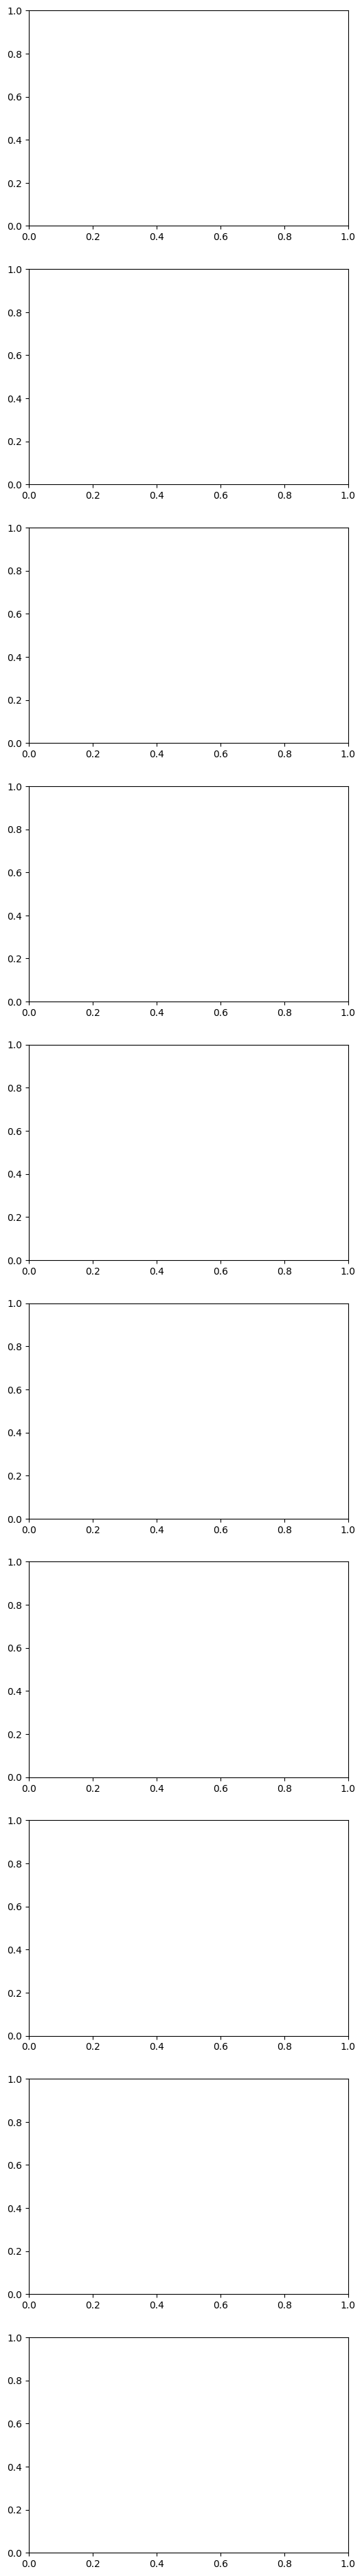

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.cm as cm

# --- File paths and corresponding Teff values ---   
science_data = [
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD164259_Hband_tellcorr_opt.fits', 6454),
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD203473_Hband_tellcorr_opt.fits', 5781),
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD199381_Hband_tellcorr_opt.fits', 5013),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL514_Hband_tellcorr_opt.fits', 3727),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL745A_Hband_tellcorr_opt.fits', 3500),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL628_Hband_tellcorr_opt.fits', 3272),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GJ876_Hband_tellcorr_opt.fits', 3129),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL555_Hband_tellcorr_opt.fits', 3211)
]

# Sort by descending Teff (hottest first, coolest last)
science_data.sort(key=lambda x: -x[1])
science_files, teff_values = zip(*science_data)

# --- Load telluric standard ---
tell = np.load('/Users/ava/Desktop/Spectral Website/data/h_fits/telluric_standardH.npz')
wave_tell, flux_tell, mask_tell = tell['wave'], tell['flux'], tell['mask']
n_orders = wave_tell.shape[0]

# --- Load science spectra ---
loaded = []
for f in science_files:
    try:
        hdu = fits.open(f)
        d = hdu[2].data[0]
        loaded.append((f, d['wave'], d['flux'], d['mask']))
        print(f" Loaded {f}")
    except Exception as e:
        print(f" Failed to load {f}: {e}")

# --- Plot setup: 1 tall column ---
fig, axes = plt.subplots(n_orders, 1, figsize=(6, 4.8 * n_orders), sharex=False)

offset = 1.2  # spacing to avoid overlap
y_labels = [f.split('/')[-1].split('_')[0] for f, _, _, _ in loaded]
colors = plt.get_cmap('tab10').colors  # darker colors

# --- Plot each spectral order ---
for i_order in range(n_orders):
    fig, ax = plt.subplots(figsize=(6, 5))  # Create one figure per order
    all_y = []

    for j, (fpath, wave, flux, mask) in enumerate(loaded):
        try:
            good = mask[i_order] > 0
            w = wave[i_order][good][50:-50] / 1e4
            f = flux[i_order][good][50:-50]
            norm = (f - np.nanmin(f)) / (np.nanmax(f) - np.nanmin(f))
            y = norm + (len(loaded) - j) * offset

            color = colors[j % len(colors)]
            ax.plot(w, y, lw=1, color=color)
            all_y.extend(y)

            if i_order in [1, 4]:
                ax.text(w[0], np.max(y), f"{y_labels[j]} ({teff_values[j]}K)",
                        fontsize=7, verticalalignment='bottom', color='black', ha='left')
        except Exception as e:
            print(f" Plot failed for {fpath} order {i_order}: {e}")

    # Telluric standard
    try:
        good_tell = mask_tell[i_order] > 0
        w_tell = wave_tell[i_order][good_tell][50:-50] / 1e4
        f_tell = flux_tell[i_order][good_tell][50:-50]
        norm_tell = (f_tell - np.nanmin(f_tell)) / (np.nanmax(f_tell) - np.nanmin(f_tell))
        y_tell = norm_tell - 0.2 * offset

        ax.plot(w_tell, y_tell, lw=1, color='black')
        if i_order in [1, 4]:
            ax.text(w_tell[0], np.max(y_tell) + 0.05, "Telluric Standard",
                    fontsize=7, verticalalignment='bottom', color='black', ha='left')
        all_y.extend(y_tell)
    except Exception as e:
        print(f" Failed to plot telluric standard for order {i_order}: {e}")

    if all_y:
        ymin = min(all_y) - 0.2
        ymax = max(all_y) + 0.4
        ax.set_ylim(ymin, ymax)

    ax.set_ylabel(r'$F_\lambda$ + constant', fontsize=9)
    ax.tick_params(axis='both', direction='out', bottom=True, top=False, left=True, right=False)
    ax.tick_params(labelrotation=0, labelsize=8)
    ax.set_yticks([])
    ax.grid(False)
    ax.set_xlabel(r'$\lambda\,(\mu m)$', fontsize=9)
    ax.set_title(f"H-band Spectral Order {i_order + 1}", fontsize=10, weight='bold')

    # Save each figure
    outname = f"/Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_stacked/h_order{i_order}.png"
    plt.tight_layout()
    plt.savefig(outname, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {outname}")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os

# --- File paths and corresponding Teff values ---   
science_data = [
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD164259_Hband_tellcorr_opt.fits', 6454),
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD203473_Hband_tellcorr_opt.fits', 5781),
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD199381_Hband_tellcorr_opt.fits', 5013),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL514_Hband_tellcorr_opt.fits', 3727),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL745A_Hband_tellcorr_opt.fits', 3500),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL628_Hband_tellcorr_opt.fits', 3272),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GJ876_Hband_tellcorr_opt.fits', 3129),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL555_Hband_tellcorr_opt.fits', 3211)
]

# Sort by descending Teff
science_data.sort(key=lambda x: -x[1])

# Load telluric standard to determine number of orders
tell = np.load('/Users/ava/Desktop/Spectral Website/data/h_fits/telluric_standardH.npz')
wave_tell, flux_tell, mask_tell = tell['wave'], tell['flux'], tell['mask']
n_orders = wave_tell.shape[0]

# Output directory
outdir = "/Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw"
os.makedirs(outdir, exist_ok=True)

# --- Plotting ---
for fpath, teff in science_data:
    try:
        hdu = fits.open(fpath)
        data = hdu[2].data[0]
        wave, flux, mask = data['wave'], data['flux'], data['mask']
        starname = os.path.basename(fpath).split('_')[0]
        print(f"Loaded {starname}")

        for i_order in range(n_orders):
            fig, ax = plt.subplots(figsize=(10, 3))  # wider and shorter

            good = mask[i_order] > 0
            w = wave[i_order][good][50:-50] / 1e4  # microns
            f = flux[i_order][good][50:-50] /1e5

            # Gentle normalization to median
            f_norm = f

            ax.plot(w, f_norm, lw=1, color='black')

            # Auto-scaling y-limits with padding
            ymin, ymax = np.min(f_norm), np.max(f_norm)
            padding = 1 * (ymax - ymin)  # 100% padding
            ax.set_ylim(ymin - padding, ymax + padding)

            # Labels and style
            ax.set_xlabel(r'$\lambda\,(\mu m)$', fontsize=9)
            ax.set_ylabel('Flux', fontsize=9)
            ax.set_title(f"{starname} - H-band Order {53 - i_order}", fontsize=11, weight='bold')

            ax.tick_params(axis='both', direction='out', bottom=True, top=False, left=True, right=False)
            ax.tick_params(labelrotation=0, labelsize=8)
            ax.grid(False)
            #ax.set_ylim(1, 5)  # Optional: squash y range

            # Save
            outname = os.path.join(outdir, f"{starname}_order{i_order}.png")
            plt.tight_layout()
            plt.savefig(outname, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"Saved: {outname}")

    except Exception as e:
        print(f"Failed to process {fpath}: {e}")

# --- Plot telluric standard separately ---
for i_order in range(n_orders):
    fig, ax = plt.subplots(figsize=(10, 3))  # wider and shorter

    good = mask_tell[i_order] > 0
    w = wave_tell[i_order][good][50:-50] / 1e4  # microns
    f = flux_tell[i_order][good][50:-50] / 1e5
    f_norm = f  # Or normalize if you prefer

    ax.plot(w, f_norm, lw=1, color='black')

    # Auto y-limits with padding
    ymin, ymax = np.min(f_norm), np.max(f_norm)
    padding = 1 * (ymax - ymin)
    ax.set_ylim(ymin - padding, ymax + padding)

    # Labels and style
    ax.set_xlabel(r'$\lambda\,(\mu m)$', fontsize=9)
    ax.set_ylabel('Flux', fontsize=9)
    ax.set_title(f"Telluric Standard - H-band Order {53 - i_order}", fontsize=11, weight='bold')

    ax.tick_params(axis='both', direction='out', bottom=True, top=False, left=True, right=False)
    ax.tick_params(labelrotation=0, labelsize=8)
    ax.grid(False)

    # Save
    outname = os.path.join(outdir, f"TelluricStd_order{i_order}.png")
    plt.tight_layout()
    plt.savefig(outname, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {outname}")



Loaded HD164259
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order0.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order1.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order2.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order3.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order4.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order5.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order6.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order7.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order8.png
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD164259_order9.png
Loaded HD203473
Saved: /Users/ava/Desktop/Spectral Website/plots/H_Plots/plots_bw/HD203473_order0.png
Saved: /Users/ava/Desk

In [3]:
import numpy as np
from astropy.io import fits
import os

# Input FITS files
science_data = [
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD164259_Hband_tellcorr_opt.fits', 6454),
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD203473_Hband_tellcorr_opt.fits', 5781),
    ('/users/ava/desktop/Spectral Website/data/h_fits/HD199381_Hband_tellcorr_opt.fits', 5013),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL514_Hband_tellcorr_opt.fits', 3727),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL745A_Hband_tellcorr_opt.fits', 3500),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL628_Hband_tellcorr_opt.fits', 3272),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GJ876_Hband_tellcorr_opt.fits', 3129),
    ('/users/ava/desktop/Spectral Website/data/h_fits/GL555_Hband_tellcorr_opt.fits', 3211)
]
# Output directory
outdir = "/Users/ava/Desktop/Spectral Website/data/h_txt"
os.makedirs(outdir, exist_ok=True)

for fpath, teff in science_data:
    try:
        hdu = fits.open(fpath)
        data = hdu[2].data[0]           # Spectral data
        wave_all, flux_all = data['wave'], data['flux']
        starname = os.path.basename(fpath).split('_')[0]
        print(f"Loaded {starname}")

        # Flatten and clean
        wave = wave_all.flatten() / 1e4  # Convert to microns
        flux = flux_all.flatten() / 1e5  # Scale flux
        mask_good = (wave > 0) & (flux != 0)
        wave = wave[mask_good]
        flux = flux[mask_good]

        # Sort by wavelength
        idx = np.argsort(wave)
        wave = wave[idx]
        flux = flux[idx]

        # Output file path
        outname = os.path.join(outdir, f"{starname}_h.txt")

        # Write header and spectrum to text file
        with open(outname, 'w') as f:
            f.write("# ================================================================\n")
            f.write(f"# FITS HEADER INFO for {starname}\n")
            f.write(f"# Extracted from: {os.path.basename(fpath)}\n")
            f.write("# ---------------------------------------------------------------\n")

            # ✅ Loop through ALL HDUs and extract headers
            for i, h in enumerate(hdu):
                f.write(f"# --- Header from HDU[{i}] ---\n")
                for key in h.header:
                    val = h.header[key]
                    comment = h.header.comments[key]
                    if key.strip() != "":
                        f.write(f"# {key: <10} = {val}  / {comment}\n")
                f.write("# ---------------------------------------------------------------\n")

            f.write("# ================================================================\n")
            f.write("# Wavelength (microns)    Flux (scaled by 1e5)\n")
            f.write("# ---------------------------------------------------------------\n")

            # Write spectral data
            for w, fl in zip(wave, flux):
                f.write(f"{w:.6f}  {fl:.6f}\n")

        print(f"✅ Saved with full FITS header: {outname}")

    except Exception as e:
        print(f"❌ Failed to process {fpath}: {e}")

Loaded HD164259
✅ Saved with full FITS header: /Users/ava/Desktop/Spectral Website/data/h_txt/HD164259_h.txt
Loaded HD203473
✅ Saved with full FITS header: /Users/ava/Desktop/Spectral Website/data/h_txt/HD203473_h.txt
Loaded HD199381
✅ Saved with full FITS header: /Users/ava/Desktop/Spectral Website/data/h_txt/HD199381_h.txt
Loaded GL514
✅ Saved with full FITS header: /Users/ava/Desktop/Spectral Website/data/h_txt/GL514_h.txt
Loaded GL745A
✅ Saved with full FITS header: /Users/ava/Desktop/Spectral Website/data/h_txt/GL745A_h.txt
Loaded GL628
✅ Saved with full FITS header: /Users/ava/Desktop/Spectral Website/data/h_txt/GL628_h.txt
Loaded GJ876
✅ Saved with full FITS header: /Users/ava/Desktop/Spectral Website/data/h_txt/GJ876_h.txt
Loaded GL555
✅ Saved with full FITS header: /Users/ava/Desktop/Spectral Website/data/h_txt/GL555_h.txt
